In [1]:
%load_ext notexbook
%texify

# `Dataset` and PyTorch

As it is customary in Machine Learning, a generic dataset is always denoted by the **feature matrix** $X$, of size $N_{samples} \times D_{features}$. 
Despite its simplicity, this *conceptual model* represents the foundation on which Machine learning (`ML`), and **Deep Learning** (`DL`) applications builds on. 

In Python, the most *obvious* implementation of this model would be using **NumPy** `ndarray`: 

1. The matrix $X$ is a `ndarray` object;
    - Also `scipy.sparse.csr` in case of sparse data;
    - 1st `axis` of `X` corresponds to `sample` dimension; 2nd axis to `features`
3. (_Supervised learning settings_) the vector $y$ of target labels would be `ndarray` object;
4. Each ML model (i.e. `sklearn.Estimator` object) expects in input `X` and `y` as `ndarray`
    - or `array-like`, to be more precise

```python
>>> estimator = Estimator(*model_params)  # generic sklearn Estimator object
>>> estimator.fit(X, y)
```

**It is indeed that simple!**

If we now try to adapt this _pseudocode_ into a more _Pytorch-alike_ syntax for deep learning:

1. `numpy.ndarray` $\mapsto$ `torch.Tensor`

```python
>>> X, y = torch.from_numpy(X), torch.from_numpy(y)
```

2. `models` are `Callable` objects in PyTorch, so no `.fit` method is required:

```python
>>> model = EstimatorNN(*params)
>>> model(X)  # X represents the whole dataset
```

So, this model _still applies_ to DL, as it also works *in practice*: the input of any PyTorch `Module` is (*at least, ed.*) a `torch.Tensor` `X` of size `samples` $\times$ `features`[$^{1}$](#fn1)

However, you would hardly see any example even remotely resembling that piece of (pseudo-)code, and the reasons for this are many!

In this notebook, we will be working on how to *encapsulate* a (generic) dataset into proper **OOP** abstractions that would either (**A**) fit perfectly into the [Python Data Model](https://docs.python.org/3/reference/datamodel.html); (**B**) provide flexible and 
easy-to-use data types that serves any specific requirement for the training of Deep neural networks.





<span id="fn1"><i>[1]: </i>Regardless of how many dimensions `features` may have.</span>

## The Zen of Data Abstractions

The general _mantra_ that we will try to support in this tutorial is:

- Data does **never** come *already* pre-processed (🚫 `MNIST`)
    - either in `features` or in `partitions`

- A dataset for DL is (and requires) more than `numpy.ndarray` $\mapsto$ `torch.Tensor`[$^{\star}$](#fnstar2)
    - same applies to `pandas.DataFrame` $\mapsto$ `torch.Tensor`

- Data Science 💙 OOP

- *good* OOP abstractions make your life a lot easier
    - and are also a lot of fun to use!
    
- FYI: **Python Data Model** rocks 🚀

I called this the *Zen of Data Abstractions* (for _deep learning_).

*Note*: I did come up with this *name* while working at this tutorial...so I presume the list is still _incomplete_ and would benefit for some revisions. 
*If only* the **Global PyData Community** would be gathered into a unique conference...

<span id="fnstar2"><i>[$^{\star}$]: </i>Although there exists an instance of `torch.utils.data.TensorDataset` 😊</span>


## Data Model for Deep Learning

In the introductory **Prelude** of this tutorial we focused on how to _represent_ data for ML algorithms. In particular, we discussed what is required to fit a generic dataset into the `samples x features` representation expected by ML/DL models. 

We also emphasized that this model also fits perfectly into the **Deep Learning** context, without any loss of generality. This is true in general, however **training** Deep Neural Networks (`DNN`) imposes new unprecedented requirements that we must consider.
The _core training algorithm_ of a (`feed-forward`) DNN is indeed very simple.

The whole process comprises **two** main phases, which are iterated up to a total number of times (i.e. `epochs`): <br /> (1) the `forward` pass (`left` $\rightarrow$ `right`); (2) the `backward` pass (`left` $\leftarrow$ `right`).

- [`Forward`]: The model gets the `inputs` data, and `outputs` are generated, based on current model parameters (i.e. `weights`);
- [`Backward`]: Errors (`loss`) are calculated, and `weights` are updated to _minimise_ these errors (following the opposite direction of the gradient, i.e. _Gradient Descent_);
- `repeat until` a max number of iterations has been performed. 


<img alt="the learning process" src="https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/2_torch_dataset/learning_process.png" class="maxw80" />

<span class="fn"><i>Source: </i> [Deep Learning with PyTorch](https://pytorch.org/deep-learning-with-pytorch)</span>

In addition, we would need to have:

- input data as organised in (*shuffled*) `mini-batches`
    - this aids optimisation;
    - this complies with memory constratints imposed by GPU architectures;
- a single training `epoch` as partitioned into the training of all the `batches` (one batch at a time)

In a *Pytorch-alike* pseudocode (*not much different from the real one, ed.*), the training algorithm would be:

```python
for epoch in range(NUM_EPOCHS):
    for batch in iter(dataset, no_replacement, shuffle=True):
        X, y_true = batch               # batch is a tuple (samples, labels)
        optimizer.zero_grad()           # zero the gradient of the optimizer
        y_hat = model(batch)            # forward pass
        loss = criterion(y_hat, y_true) # calculate errors
        loss.backward()                 # backward pass
        optimizer.step()                # optimisation step
```

So, we need a `Dataset` abstraction that it is **subscriptable** (e.g. `dataset[i]`, or 
`dataset[batch_start:batch_end]`), and **iterable**. 

In particular, the iteration protocol should be flexible enough to adapt to different requirements, e.g. *shuffling* is required or not, sampling *with* or *without* replacement.
In these circumstances, we would presumably need a different `object` to just deal with this iteration protocol for a given input `dataset`. 

**Last but not least**: <ins>*Data Augmentation*</ins> should be also be considered as an extra (DL-specific) requirement. Our abstraction should easily allow to include data augmentantion easily. 

### From `Bunch` to `Dataset`

If we are transitioning from `sklearn` (ML) to `torch` (DL), we are very used to think of our ML data in terms of `numpy` arrays (and other supported variants, i.e. `scipy.sparse.csr` or `pandas.DataFrame`).

However, it is now clear that we need something more.

`sklearn` indeed has its own general [`dataset` API](https://scikit-learn.org/stable/datasets/index.html#general-dataset-api) whenever a new dataset is loaded:

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

print(type(iris))

<class 'sklearn.utils._bunch.Bunch'>


In [3]:
from sklearn.utils import Bunch

Bunch?

Init signature: Bunch(**kwargs)
Docstring:     
Container object exposing keys as attributes.

Bunch objects are sometimes used as an output for functions and methods.
They extend dictionaries by enabling values to be accessed by key,
`bunch["value_key"]`, or by an attribute, `bunch.value_key`.

Examples
--------
>>> from sklearn.utils import Bunch
>>> b = Bunch(a=1, b=2)
>>> b['b']
2
>>> b.b
2
>>> b.a = 3
>>> b['a']
3
>>> b.c = 6
>>> b['c']
6
File:           ~/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/utils/_bunch.py
Type:           type
Subclasses:     


A `sklearn.utils.Bunch` object is a class that maps dictionary keys into class fields (*brilliant, ed.*):

In [4]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [5]:
X = iris.data  # same as iris["data"]

This is definitely a first step towards a more OOP-oriented data encapsulation, and *metadata* are handled brilliantly with this abstraction. However, we still need a more flexible strategy to handle data *in-memory*:

`torch.utils.data.Dataset` is an abstract class representing a dataset in `torch`. 

Any custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support a dataset which is **subscriptable** for sample indexing, or batch slicing. 

**Just simple as that** !

---

## Case Study: `Magic: The Gathering` Dataset

Let's finally workout our first case **full** case study, working with MTG cards.

This dataset is interesting at so many level, and it will be used here, and in next parts as reference example.

### Gathering Magic data: Scryfall.com

In [6]:
%%writefile utils.py

import os
from pathlib import Path
import json
import requests
import sys
from tqdm import tqdm
from functools import partial 

SCRYFALL_DEFAULT_CARDS_URL = (
    "https://data.scryfall.io/default-cards/default-cards-20221103090502.json"
)
DATA_FOLDER = Path(os.path.abspath(os.path.curdir)) / "data"
SCRYFALL_DB = DATA_FOLDER / "default_cards.json"

def download_and_save(dbfile=SCRYFALL_DB, dbfile_url=SCRYFALL_DEFAULT_CARDS_URL):
    print("Downloading DB file (Default Cards) from Scryfall")
    # Streaming, so we can iterate over the response.
    response = requests.get(dbfile_url, stream=True)
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    block_size = 4096  # 4 Kibibyte
    progress_bar = tqdm(
        total=total_size_in_bytes, unit="iB", unit_scale=True, file=sys.stdout
    )
    with open(dbfile, "wb") as scryfall_db:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            scryfall_db.write(data)
    progress_bar.close()
    print(f"DB file saved in {dbfile}!")
    

def load_scryfall_dbjson(
    dbfile=SCRYFALL_DB, dbfile_url=SCRYFALL_DEFAULT_CARDS_URL
) -> dict:
    def json_hook(obj, pbar):
        pbar.update(1)
        return obj

    if not dbfile.exists():
        print("DB file does not exist!")
        download_and_save(dbfile=dbfile, dbfile_url=dbfile_url)

    # For Performance Issues, load (BIG ~= 1.20GB) JSON DB from Scryfall just once
    with open(dbfile) as scryfalldb_file:
        print("Loading Full Database file")
        pbar = tqdm(ascii=True, desc="Cards", unit="", file=sys.stdout)
        hook = partial(json_hook, pbar=pbar)
        scryfall_db = json.load(scryfalldb_file, object_hook=hook)
        pbar.close()
    return scryfall_db

Overwriting utils.py


Now that we are all set with our utilities, let's move on to our **data abstractions**

In [7]:
%%writefile cards.py

from collections import namedtuple
from dataclasses import dataclass
from enum import Enum


CardImagery = namedtuple(
    "CardImagery", ["border_crop", "art_crop", "large", "normal", "small"]
)

class Color(Enum):
    W = 1
    U = 2
    B = 3
    R = 4
    G = 5

@dataclass
class Card:
    cid: str
    name: str 
    lang: str 
    set_code: str
    set_name: str
    set_type: str
    artist: str
    frame: str
    legalities: dict
    color_identity: list[Color] = None
    art: CardImagery = None
    

Overwriting cards.py


Let's now define a `ScryfallDB` class.

**note** this is going to be the **skeleton** for our PyTorch `Dataset` class

In [8]:
%%writefile scryfalldb.py

from utils import load_scryfall_dbjson
from utils import SCRYFALL_DB, SCRYFALL_DEFAULT_CARDS_URL
from cards import Card, CardImagery, Color
from typing import Tuple, Iterable, Sequence, Dict, Optional
from functools import reduce, partial
from operator import and_, is_
from collections import defaultdict

class ScryfallDB:
    """Cards ScryfallDB"""

    def __init__(
        self, dbfile:str = SCRYFALL_DB, db_preloaded:dict = None, 
        dbfile_url:str = SCRYFALL_DEFAULT_CARDS_URL):
        if db_preloaded is None:
            self._db_file = dbfile
            self._db: dict = load_scryfall_dbjson(dbfile=dbfile, dbfile_url=dbfile_url)
        else:
            self._db_file = None
            self._db = db_preloaded

        self._cards_map = defaultdict(list)
        print("\nLoading Cards from Database into Oracle")
        self._load_cards_from_db()
        self._expansion_codename_map = self._load_codename_map()

    def _load_cards_from_db(self):
        for entry in self._db:
            if entry["lang"] != "en":
                continue
            if (
                entry["games"]
                and len(entry["games"]) == 1
                and entry["games"][0] == "mtgo"
            ):
                continue  # skip Online-only Expansion Promo Sets
            if "image_uris" in entry:
                card_imagery = CardImagery(
                    border_crop=entry["image_uris"]["border_crop"],
                    art_crop=entry["image_uris"]["art_crop"],
                    large=entry["image_uris"]["large"],
                    normal=entry["image_uris"]["normal"],
                    small=entry["image_uris"]["small"],
                )
            else:
                card_imagery = None

            if "color_identity" in entry:
                color_identity = [Color[v.upper()].value for v in entry["color_identity"]]
            else:
                color_identity = None

            card = Card(
                cid=entry["id"],
                name=entry["name"],
                lang=entry["lang"],
                set_code=entry["set"],
                set_name=entry["set_name"],
                set_type=entry["set_type"],
                art=card_imagery,
                artist=entry["artist"],
                frame=entry["frame"],
                legalities=entry["legalities"],
                color_identity=color_identity
            )
            dbentry = self.make_dbentry(card.name)
            self._cards_map[dbentry].append(card)

    @staticmethod
    def make_dbentry(name: str) -> str:
        return name.lower().replace(" ", "-")

    def lookup(
        self,
        card_name: Optional[str] = None,
        expand_search: bool = False,
        doubles_only: bool = False,
        unique: bool = False,
        set_code: str = None,
        set_type: str = None,
    ) -> Iterable[Card]:
        """Lookup for Cards in the DB with the specified name.

        Parameters
        ----------
        card_name: str (default None)
            Name of the card to look up (case-insensitive)
            If No Name is provided, a lookup by set_code and/or set_type will be enabled (if any).
        expand_search: bool (default False)
            If True, the search for card_name will be extended also to non-exact matches.
            Some options are available:
            1. SUFFIX-search (e.g. *ice)
            2. PREFIX-search (e.g. ice*)
            3. SUFFIX and PREFIX search (joint results, e.g. *ice*)
            4. WHOLE-WORD search: only cards in the db containing the whole words in `card_name` are returned
                (e.g. "spring")
            Note: Passing in just "*" as card_name will be treated as emptry string (i.e. NO card name)
            Full DB lookup is pointless, just iterating over the Oracle would be good for that.
        doubles_only: bool (default False)
            If True, expanded search will be only limited to double cards (e.g. Fire // Ice)
            NOTE: This option will be ignored, if expanded_search is False!
        unique: bool (default False)
            If True, only one entry per Card will be returned (usually used with expanded search).
            NOTE: If no set_code nor set_type is specified, the first entry for each retrieved card (if any)
            is returned.
        set_code: str (default None)
            If speficied, cards' version from the speficied `set_code` will be returned.
            If the search won't produce any result, the set_code will be automatically tried
            as a prefix, before giving up.
        set_type: str, allowed: ("expansion", "promo", "memorabilia", "premium_deck, "funny") (default None)
            If speficied, the list of results will be further filtered by returning only sets of the
            specified type.
        Return
        ------
            (Lazy) Iterable sequence of retrieved Card instances matching the speficied criteria.
            Empty result set will be returned if no match is found in the DB.
        """
        allowed_set_types = (
            "promo",
            "expansion",
            "memorabilia",
            "premium_deck",
            "funny",
        )
        if set_type and not set_type in allowed_set_types:
            return ValueError(
                f"Input set type {set_type} Not Recognised. Values allowed are {allowed_set_types}"
            )

        is_card = (card_name is not None) and len(card_name.replace("*", ""))
        is_set = set_code is not None
        is_set_type = set_type is not None
        if not any((is_card, is_set, is_set_type)):
            return self._result_set([])

        if is_card:
            card_dbentry = self.make_dbentry(card_name)
            entries = self._cards_map.get(card_dbentry, [])

            if not entries and not expand_search:
                return self._result_set([])  # Empty result

            if expand_search:
                # set cards pool of reference
                if doubles_only:
                    cards_pool = filter(lambda c: "//" in c.name, self.all_cards)
                else:
                    cards_pool = self.all_cards
                # set filter function
                if card_name.startswith("*") and card_name.endswith("*"):
                    card_name = card_name[1:-1].lower()
                    f = lambda c: c.name.lower().startswith(
                        card_name
                    ) or c.name.lower().endswith(card_name)
                elif card_name.startswith("*"):  # SUFFIX
                    card_name = card_name[1:].lower()
                    f = lambda c: c.name.lower().endswith(card_name)
                elif card_name.endswith("*"):  # PREFIX
                    card_name = card_name[:-1].lower()
                    f = lambda c: c.name.lower().startswith(card_name)
                else:  # WHOLE-WORD lookup
                    f = lambda c: self._isin(card_name, c.name)
                expanded_search = filter(f, cards_pool)
                entries.extend(expanded_search)
            entries = tuple(entries)  # make an immutable sequence
        else:
            entries = self.all_cards

        # Lookup by set_code
        if is_set:
            if set_code in self._expansion_codename_map:
                filter_func = lambda c: c.set_code == set_code
            else:
                filter_func = lambda c: c.set_code.startswith(set_code)
            entries_set = tuple(filter(filter_func, entries))
            if not entries_set:
                return self._result_set(())  # Empty result
            entries = entries_set
        # Lookup by set_type
        if is_set_type:
            entries = tuple(filter(lambda c: c.set_type == set_type, entries))
        # filter unique values
        if unique:
            entries_map = dict()
            for e in entries:
                _ = entries_map.setdefault(e.name, e)
            entries = tuple(c for c in entries_map.values())
        return self._result_set(entries)

    @staticmethod
    def _result_set(entries: Sequence[Card]) -> Iterable[Card]:
        if not entries:
            return iter(tuple())  # empty set
        else:
            for e in entries:
                yield e

    @staticmethod
    def _isin(card_name: str, db_entry: str) -> bool:
        db_entry_words = db_entry.lower().split()
        return reduce(
            and_, map(lambda n: n in db_entry_words, card_name.lower().split())
        )

    def __len__(self) -> int:
        return sum(map(len, self._cards_map.values()))

    def __contains__(self, card_name: str) -> bool:
        return len(tuple(self.lookup(card_name))) > 0

    def __getitem__(self, card_name: str) -> Tuple[Card]:
        """proxy for lookup with just the card name specified"""
        return tuple(self.lookup(card_name))

    def __iter__(self) -> Iterable[Card]:
        return self.all_cards

    def _load_codename_map(self) -> Dict[str, str]:
        codename_seq = set()
        for entry in self:
            set_code, set_name = entry.set_code, entry.set_name
            codename_seq.add((set_code, set_name))
        return {code: name for code, name in codename_seq}

    @property
    def expansion_codename_map(self) -> Dict[str, str]:
        """returns a dictionary mapping expansion codes to their corresponding full names"""
        if not self._expansion_codename_map:
            self._expansion_codename_map = self._load_codename_map()
        return self._expansion_codename_map

    @property
    def all_cards(self) -> Iterable[Card]:
        for cards in self._cards_map.values():
            for card in cards:
                yield card

    def add_expansion_code(self, codename: Tuple[str, str]) -> None:
        """Method to add any Code-Name expansion set found in the MTG-Manager data
        that is  "missing" from Scryfall"""
        set_code, set_name = codename
        self.expansion_codename_map[set_code] = set_name

Overwriting scryfalldb.py


In [9]:
from scryfalldb import ScryfallDB

card_db = ScryfallDB()

Loading Full Database file
Cards: 449738 [00:06, 73615.02/s] 

Loading Cards from Database into Oracle


In [10]:
from IPython.display import Image, display

**Example 1.** Gathering multiple versions of the same card:

```python
card_db.lookup(card_name=name)
```

In [11]:
results = card_db.lookup("Shivan Dragon")
for card in results: 
    print(f"{card.name}, {card.set_name}({card.set_code})")
    print(f"Art from {card.artist}")
    display(Image(url=card.art.small))

Shivan Dragon, Oversized 90's Promos(o90p)
Art from Melissa A. Benson


Shivan Dragon, Collectors’ Edition(ced)
Art from Melissa A. Benson


Shivan Dragon, Tenth Edition(10e)
Art from Donato Giancola


Shivan Dragon, Welcome Deck 2017(w17)
Art from Donato Giancola


Shivan Dragon, Core Set 2020(m20)
Art from Donato Giancola


Shivan Dragon, Magic 2014(m14)
Art from Donato Giancola


Shivan Dragon, Intl. Collectors’ Edition(cei)
Art from Melissa A. Benson


Shivan Dragon, Beatdown Box Set(btd)
Art from Melissa A. Benson


Shivan Dragon, 30th Anniversary Edition(30a)
Art from Melissa A. Benson


Shivan Dragon, Ninth Edition(9ed)
Art from Donato Giancola


Shivan Dragon, Limited Edition Beta(leb)
Art from Melissa A. Benson


Shivan Dragon, Tenth Edition(10e)
Art from Donato Giancola


Shivan Dragon, Fifth Edition(5ed)
Art from Melissa A. Benson


Shivan Dragon, From the Vault: Dragons(drb)
Art from Justin Sweet


Shivan Dragon, Revised Edition(3ed)
Art from Melissa A. Benson


Shivan Dragon, Duels of the Planeswalkers(dpa)
Art from Donato Giancola


Shivan Dragon, Fourth Edition(4ed)
Art from Melissa A. Benson


Shivan Dragon, Seventh Edition(7ed)
Art from Donato Giancola


Shivan Dragon, Game Night: Free-for-All(gn3)
Art from Donato Giancola


Shivan Dragon, Jumpstart: Historic Horizons(j21)
Art from Donato Giancola


Shivan Dragon, 30th Anniversary Edition(30a)
Art from Melissa A. Benson


Shivan Dragon, Magic 2015(m15)
Art from Donato Giancola


Shivan Dragon, Summer Magic / Edgar(sum)
Art from Melissa A. Benson


Shivan Dragon, Magic Origins(ori)
Art from Donato Giancola


Shivan Dragon, Fifth Edition(5ed)
Art from Melissa A. Benson


Shivan Dragon, Secret Lair 30th Anniversary Countdown Kit(slc)
Art from Justine Jones


Shivan Dragon, Magic 2010(m10)
Art from Donato Giancola


Shivan Dragon, Welcome Deck 2016(w16)
Art from Donato Giancola


Shivan Dragon, Core Set 2019(m19)
Art from Donato Giancola


Shivan Dragon, Eighth Edition(8ed)
Art from Donato Giancola


Shivan Dragon, Unlimited Edition(2ed)
Art from Melissa A. Benson


Shivan Dragon, Limited Edition Alpha(lea)
Art from Melissa A. Benson


**Example 2.**: Gathering all the cards from a single set:

```python
# cards from Ice Age (ICE) set
card_db.lookup(set_code="ice")
```

In [12]:
iceage_cards = card_db.lookup(set_code="ice")
for i, card in enumerate(iceage_cards): 
    print(f"{i+1}) {card.name} from {card.set_name}")

1) Swamp from Ice Age
2) Swamp from Ice Age
3) Swamp from Ice Age
4) Island from Ice Age
5) Island from Ice Age
6) Island from Ice Age
7) Plains from Ice Age
8) Plains from Ice Age
9) Plains from Ice Age
10) Forest from Ice Age
11) Forest from Ice Age
12) Forest from Ice Age
13) Mountain from Ice Age
14) Mountain from Ice Age
15) Mountain from Ice Age
16) Nature's Lore from Ice Age
17) Thermokarst from Ice Age
18) Elvish Healer from Ice Age
19) Lhurgoyf from Ice Age
20) Icy Manipulator from Ice Age
21) Enduring Renewal from Ice Age
22) Brainstorm from Ice Age
23) Dark Banishing from Ice Age
24) Hydroblast from Ice Age
25) Circle of Protection: Blue from Ice Age
26) Gorilla Pack from Ice Age
27) Shatter from Ice Age
28) Swords to Plowshares from Ice Age
29) Ice Floe from Ice Age
30) Fyndhorn Brownie from Ice Age
31) Orcish Healer from Ice Age
32) Jester's Cap from Ice Age
33) Dark Ritual from Ice Age
34) Nacre Talisman from Ice Age
35) Word of Blasting from Ice Age
36) Giant Growth from

In [13]:
# Visualising last card
display(Image(url=card.art.small))

#### Quick Exercise: 
Gather and print all the cards from the **Mirrodin** (`MRD`) set

In [14]:
## your code here


##### Another (quick) Exercise

Visualise the card named "Swamp" from both `ICE` and `MRD`

**MTG Note**: FYI, Swamp is a _special_ card as it is a **basic land**, those cards that can give you the coloured mana to play other spells. In particular, the five types of basic lands for the five colours of Magic are `Plains`, `Islands`, `Swamp`, `Mountain`, `Forest` for `W, U, B, R, G` colours, respectively.

```python
# fill in the gaps

ice_swamps = card_db.lookup("Swamp", set_code="ice")
mrd_swamps = card_db.lookup("Swamp", set_code="...")

for iag_swamp, mrd_swamp in zip(...):
    display(Image(url=iag_swamp.art.small))
    display(...)
```


In [15]:
## YOUR CODE HERE

🙋‍♂️ What can you notice from the results? 

#### From ScryfallDB to MTGDataset

In order to process this data into a PyTorch pipeline, we need to create our own version of `Custom` Dataset.

The easiest would be wrapping around the `ScryfallDB` class.

In [38]:
%%writefile dataset.py

import os 
from utils import DATA_FOLDER
from scryfalldb import ScryfallDB
from torch.utils.data import Dataset 
from typing import Callable, TypeVar
from PIL import Image as PILImage
import requests
from io import BytesIO

Image = TypeVar("Image")
Tensor = TypeVar("Tensor")

Transform_fn = Callable[[Image], Tensor]

CARDS_FOLDER = DATA_FOLDER / "cards"
os.makedirs(CARDS_FOLDER, exist_ok=True)


class MTGDataset(Dataset):
    def __init__(self, lookup_filters: dict[str, str] = None, 
                 transform: Transform_fn = None):
        self._lookup_filters = lookup_filters
        self._transform = transform
        self._db = ScryfallDB()
        if self._lookup_filters:
            self._cards = list(self._db.lookup(**self._lookup_filters))
        else:
            self._cards = list(self._db.all_cards)
            
    def __getitem__(self, index):
        card = self._cards[index]
        url = card.art.small
        os.makedirs(CARDS_FOLDER / card.set_code.lower(), exist_ok=True)
    
        card_uri = f"{CARDS_FOLDER / card.set_code.lower() / card.name.replace(' ', '-').lower()}.jpg"
        
        if not os.path.exists(card_uri):
            response = requests.get(url)
            img = PILImage.open(BytesIO(response.content))
            img.save(card_uri)
        else:
            img = PILImage.open(card_uri)
        
        if self._transform:
            img = self._transform(img)
        return img, (label:=card.set_code)
    
    def __len__(self):
        return len(self._cards)
        

Overwriting dataset.py


In [17]:
from dataset import MTGDataset

In [18]:
iceage_dataset = MTGDataset(lookup_filters={"set_code": "ice"})

Loading Full Database file
Cards: 449738 [00:06, 68851.19/s] 

Loading Cards from Database into Oracle


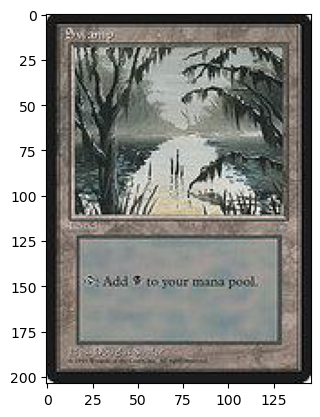

In [19]:
from matplotlib import pyplot as plt 
import numpy as np

img, label = iceage_dataset[0]
plt.imshow(np.asarray(img))
plt.show()

##### Exercise: 

Show the first 10 samples in the Dataset, with their corresponding class label (spoiler: always the same 😬)

In [20]:
## YOUR CODE HERE

----

Before we move on to the next step, let's try to complicate slightly the example we have worked on so far, to prepare the data ready for ML experiment.

In other words, `PIL.Image` instances for samples are **not** a good format for PyTorch to digest. 
We need to `transform` (_ring any bells? ed._) samples' features from `PIL.Image` instances to `torch.Tensor`.

We will be doing this quickly thanks to `torchvision.transforms` 

In [21]:
from torchvision.transforms import ToTensor, PILToTensor

In [22]:
iceage_dataset = MTGDataset(lookup_filters={"set_code": "ice"}, transform=PILToTensor())


Loading Full Database file
Cards: 449738 [00:06, 74249.16/s] 

Loading Cards from Database into Oracle


In [23]:
from matplotlib import pyplot as plt 
import numpy as np

img, label = iceage_dataset[0]
print(img, label)

tensor([[[251, 252, 255,  ..., 249, 255, 244],
         [255, 255,  66,  ..., 100, 232, 255],
         [255,  88,   1,  ...,   0,  86, 247],
         ...,
         [252,  52,   8,  ...,   5, 105, 242],
         [245, 251,  80,  ...,  76, 221, 255],
         [249, 254, 245,  ..., 252, 255, 255]],

        [[247, 248, 255,  ..., 250, 255, 244],
         [254, 255,  65,  ..., 101, 232, 255],
         [255,  87,   0,  ...,   0,  86, 247],
         ...,
         [255,  56,  12,  ...,   6, 105, 242],
         [249, 255,  84,  ...,  77, 221, 255],
         [251, 255, 247,  ..., 252, 255, 255]],

        [[244, 245, 253,  ..., 252, 255, 244],
         [251, 253,  63,  ..., 103, 232, 255],
         [253,  85,   0,  ...,   2,  86, 247],
         ...,
         [255,  59,  15,  ...,   8, 105, 242],
         [250, 255,  85,  ...,  79, 221, 255],
         [250, 255, 246,  ..., 252, 255, 255]]], dtype=torch.uint8) ice


In [24]:
img.shape

torch.Size([3, 204, 146])

---

So, the dataset is **subscriptable** as required, and we can easily `iter`-ate it to access single samples. 

However, as already anticipated, we can do a lot better... also because we need more!  And `torch` provides better abstractions to iterate over a `Dataset`: `torch.utils.data.DataLoader`!

### Iteration Time

In the previous example, we demonstrated that we can easily use a generic Python `iterator` object to iterate over samples of a `Dataset`. 

A `Dataset` object is indeed subscriptable, therefore is is always possible to do so. 

However, in doing so we would be missing out a lot of features:

- Batching the data
- Shuffling the data
- Load the data in parallel using `multiprocessing` workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. 

Parameters used below should be clear:

- `shuffle=False` whether to shuffle the samples (only required in training)
- `dataset`: the dataset to iterate
- `batch_size`: the size of each `batch`, that is: "how many samples per single batch"
- `num_workers`: how many worker processess will be used to load
- `collate_fn`

One parameter of interest is `collate_fn`, which is the function that a `Dataloader` instance calls internally to **prepare** the batches. 

The `default_collate_fn` however works fine in `90%` of the cases. For example, with our `MTGDataset` instance:

1. each `__getitem__` call returns a `tuple` `(torch.Tensor[3, 204, 146], str)`

2. The `default_collate_fn` collects a `batch_size` number of those dictionaries, and stack samples together so that:
    - `batch` $\mapsto$ `[(Tensor[batch_size, 3, 204, 146]`, `Tensor[batch_size])]`
 

In [25]:
from torch.utils.data import DataLoader

In [26]:
data_loader = DataLoader(iceage_dataset, batch_size=4, num_workers=0, shuffle=False)

In [27]:
batch = next(iter(data_loader))

In [28]:
type(batch)

list

In [29]:
batch[0].shape

torch.Size([4, 3, 204, 146])

In [30]:
batch[1]

('ice', 'ice', 'ice', 'ice')

To **customise** our `collate_fn`, we will be wrapping the result of the `default_collate_fn` implementation into a `Batch` namedtuple, for easier fields access:

In [31]:
from collections import namedtuple

from torch.utils.data.dataloader import default_collate

Batch = namedtuple("Batch", ["cards", "set_code"])

def batch_collate_fn(batch):
    batch = default_collate(batch)
    return Batch(*batch)

data_loader = DataLoader(iceage_dataset, batch_size=4, num_workers=0,
                         collate_fn=batch_collate_fn, shuffle=False)

In [32]:
batch = next(iter(data_loader))

type(batch)

__main__.Batch

In [33]:
batch.cards.shape

torch.Size([4, 3, 204, 146])

In [34]:
batch.set_code

('ice', 'ice', 'ice', 'ice')

Finally, let's have a go with our `validation_loader` to show some batches. 

We will be using the `make_grid` function from `torchvision.utils` for quicker plotting

In [35]:
from torchvision.utils import make_grid

Card Set: ('ice', 'ice', 'ice', 'ice')


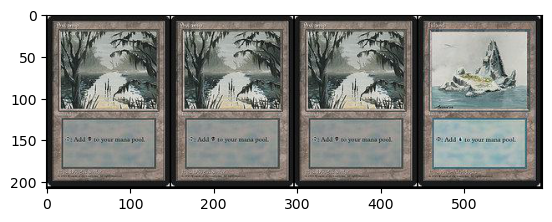

Card Set: ('ice', 'ice', 'ice', 'ice')


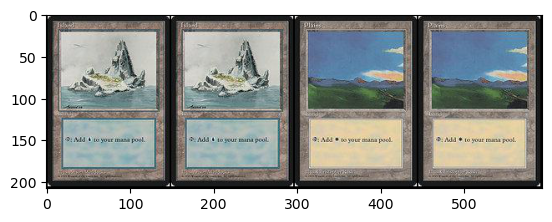

Card Set: ('ice', 'ice', 'ice', 'ice')


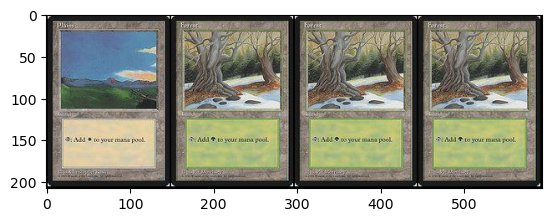

Card Set: ('ice', 'ice', 'ice', 'ice')


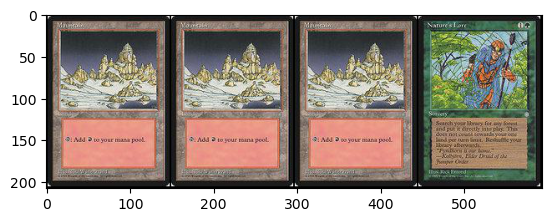

In [36]:
for i, batch in enumerate(data_loader):
    print(f"Card Set: {batch.set_code}")
    grid = make_grid(batch.cards)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    
    if i == 3:
        break